In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from mvpa2.suite import *

/Users/dan/anaconda3/lib/python3.6/site-packages/mvpa2/base/dochelpers.py:167: FutureWarning: split() requires a non-empty pattern match.
  entries = __re_spliter1.split(paramdoc)
Failed to import duecredit due to No module named 'duecredit'
/Users/dan/anaconda3/lib/python3.6/site-packages/mvpa2/base/dochelpers.py:167: FutureWarning: split() requires a non-empty pattern match.
  entries = __re_spliter1.split(paramdoc)


 * Please note: warnings are printed only once, but underlying problem might occur many times *


/Users/dan/anaconda3/lib/python3.6/site-packages/mvpa2/base/dochelpers.py:167: FutureWarning: split() requires a non-empty pattern match.
  entries = __re_spliter1.split(paramdoc)
/Users/dan/anaconda3/lib/python3.6/site-packages/mvpa2/base/dochelpers.py:167: FutureWarning: split() requires a non-empty pattern match.
  entries = __re_spliter1.split(paramdoc)
/Users/dan/anaconda3/lib/python3.6/site-packages/mvpa2/datasets/sources/skl_data.py:32: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argnames, varargs, varkw, defaults = inspect.getargspec(fx)
<string>:60: DeprecationWarning: invalid escape sequence \#
<string>:59: DeprecationWarning: invalid escape sequence \#
<string>:59: DeprecationWarning: invalid escape sequence \#
<string>:65: DeprecationWarning: invalid escape sequence \c
/Users/dan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecate

# 都道府県の自己組織化マップ

[都道府県データランキング](http://uub.jp/pdr/)
 
 上のデータランキングのデータを適当に組合せて、kendata.csv というデータを作成した。
 生データは一番下にしてある。
 
 # １．データの読み込み


In [2]:
data = pd.read_csv("kendata.csv", delimiter=",", encoding="utf-8")  # header がない場合は header=None
data.head() # 上から５データ分表示

,都道府県,人口,面積,人口密度,外国人,国籍不詳率,公務員,産業動物,小動物診療
0,愛知県,7507691,5173,1451,160228,0.0103,1671,395,92
1,愛媛県,1374881,5676,242,7828,0.0058,397,123,34
2,茨城県,2907262,6097,477,40477,0.0022,1145,216,124
3,岡山県,1915401,7114,269,18476,0.0074,596,157,82
4,沖縄県,1439913,2281,631,7651,0.0057,450,177,58


特に深い意味はない。都道府県別の人口、面積、外国人の人数などの基礎データと、公務員より右は獣医師の人数である。  
都道府県名を除く解析に使う部分の見出しを ** dataindex ** として抜き出しておく。

In [3]:
dataindex = data.columns[1:]
dataindex

Index(['人口', '面積', '人口密度', '外国人', '国籍不詳率', '公務員', '産業動物', '小動物診療'], dtype='object')

都道府県名は解析には使わないがマップに表示するために、** pref ** という配列として取り出しておく。

In [4]:
pref = data['都道府県']
pref.head()

0    愛知県
1    愛媛県
2    茨城県
3    岡山県
4    沖縄県
Name: 都道府県, dtype: object

なお、dataindex, pref などの変数名はなんでもかまわない。他と混同しないわかりやすい名前であればよい。  



In [5]:
X = data[dataindex]
X.head()

,人口,面積,人口密度,外国人,国籍不詳率,公務員,産業動物,小動物診療
0,7507691,5173,1451,160228,0.0103,1671,395,92
1,1374881,5676,242,7828,0.0058,397,123,34
2,2907262,6097,477,40477,0.0022,1145,216,124
3,1915401,7114,269,18476,0.0074,596,157,82
4,1439913,2281,631,7651,0.0057,450,177,58


# ２．標準化、正規化
解析に使うデータ部分だけを抜き出した変数を X とする。項目ごとにデータの粒度が違うので標準化、もしくは正規化して使う。

# 標準化

In [6]:
# 正規化
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler()  # 正規化
sc = StandardScaler()
stdX = sc.fit_transform(X) 
#  stdX には X が標準化されたデータが格納される。この操作で pandas dataframe から 普通の numpy 配列に変わる。

stdX[0:5] # 上から５つ表示

array([[ 1.77058323, -0.2539465 ,  0.66914529,  2.21006808,  1.15870098,
         1.04145165,  1.43458853,  0.02659779],
       [-0.48865647, -0.20770666, -0.3484878 , -0.48092962, -0.007721  ,
        -0.53972541, -0.59437261, -0.3452257 ],
       [ 0.07585083, -0.16900493, -0.15068484,  0.09556896, -0.94085858,
         0.38862659,  0.09935307,  0.23174178],
       [-0.28953661, -0.07551405, -0.3257615 , -0.29291293,  0.40700682,
        -0.29274406, -0.34075247, -0.03750971],
       [-0.46469961, -0.51980258, -0.02106078, -0.48405499, -0.03364148,
        -0.47394646, -0.19156415, -0.1913677 ]])

# ３．SimpleSOMMapper による SOM 生成 
今回は [PyMVPA](http://www.pymvpa.org/)という統計的機械学習ライブラリの [**SimpleSOMMapper**](http://www.pymvpa.org/generated/mvpa2.mappers.som.SimpleSOMMapper.html#mvpa2.mappers.som.SimpleSOMMapper)を使ってみる。

[somのサンプル](http://www.pymvpa.org/examples/som.html)があるのでそれを参考に。

In [7]:
som = SimpleSOMMapper((20,30),400, learning_rate=0.05)
som.train(stdX)

あっけないことに、これで自己組織化が完了する。 
(20,30) はマップのサイズ、 400 は繰り返し回数、learning_rate は学習係数

> ** SimpleSOMMapper(kshape, niter,  learning_rate, iradius, distance_metric)  **
>> **kshape** : (int, int)  競合層のサイズ  
>> **niter** : int   繰り返し学習回数  
>> **iradius** :  float  or None(default)    指定した場合はガウスフィルタのサイズ、None ならば競合層の長い方のサイズにセットされる。
この値は学習の経過とともに徐々に小さくなっていく。（なるほど）  
>> 他にいくつかパラメータがあるが省略

## som の内部変数とメソッド
- som.K   作成されたマップ　(20,30,n) という shape の numpy 配列である。 n は 学習データの次元数。この例では　８　
- som.train(data)   data を元にSOMを作成する。
- som.forward1(data)   data のマップ先＝ data と最も距離の近い係数を持つ マップ上のノードを返す  (自作のget_winnerメソッドと同じ） 


In [8]:
#  例えば、愛知のデータはどこにマッピングされるかを知りたければ、
som.forward1([ 1.77058323, -0.2539465 ,  0.66914529,  2.21006808,  1.15870098,
         1.04145165,  1.43458853,  0.02659779])

array([12, 26])

In [9]:
from sklearn.cluster import KMeans

def kmeans(M,k,itr):   # 配列Mの要素を対象として k-Means 法でクラスタリングを実行する　　k クラスタ数、 itr 繰り返し処理回数
    row = M.shape[0]
    col = M.shape[1]
    ch = M.shape[2]
    data = M.reshape(col*row,ch)
    km = KMeans(n_clusters=k,init='random',n_init=1,max_iter=itr,random_state=1)
    labelimage = (km.fit(data).labels_).reshape(row,col)
    centers = km.cluster_centers_
    return labelimage, centers 

# 境界の描画
def plotBoundary(labels, somcenters, cmap='tab20', colorbar=True):
    row = labels.shape[0]
    col = labels.shape[1]
    
    YY,XX = np.mgrid[0:row, 0:col] # make a grid    
    
    plt.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10) 
    
    if colorbar:
        plt.colorbar()
        
    for index, p in enumerate(somcenters):
        plt.text(p[1],p[0],str(index),ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.3, lw=0))

def writePref(som, pref, data, dataindex):
     for index, pname in enumerate(pref):
        d1 =  np.array(data[index])
        (y,x)= som.forward1(d1)
        plt.text(x,y,pref.loc[index],ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.2, lw=0))   

# 4 K-means 法によるSOMマップのクラスタリング

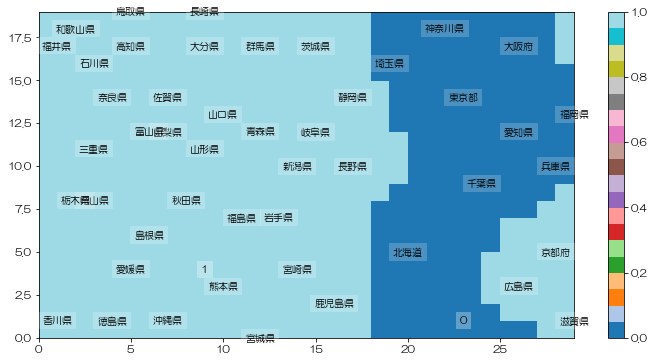

In [10]:
# 2-means
W = som.K
labelimage, centers = kmeans(W,2,100)
somcenters = [som.forward1(c)  for c in centers]
plt.rcParams['font.family'] = 'HGMaruGothicMPRO'
fig = plt.figure(figsize=(12,6))
plotBoundary(labelimage, somcenters)
writePref(som,pref,stdX,dataindex)

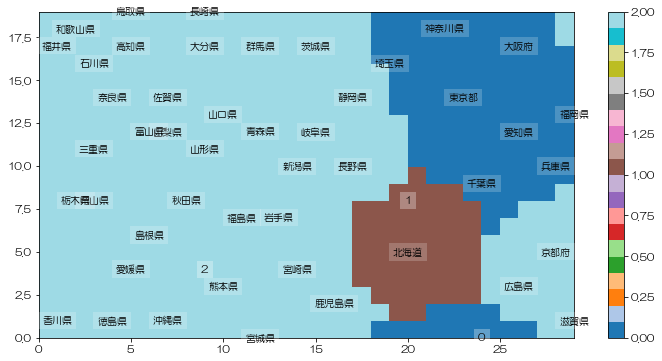

In [11]:
# 3-means
W = som.K
labelimage, centers = kmeans(W,3,100)
somcenters = [som.forward1(c)  for c in centers]
plt.rcParams['font.family'] = 'HGMaruGothicMPRO'
fig = plt.figure(figsize=(12,6))
plotBoundary(labelimage, somcenters)
writePref(som,pref,stdX,dataindex)

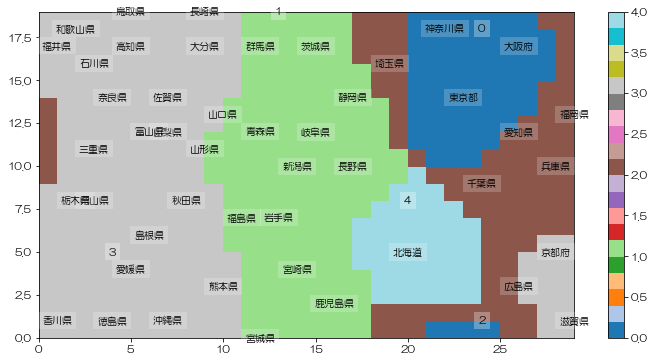

In [12]:
# 5-means
W = som.K
labelimage, centers = kmeans(W,5,100)
somcenters = [som.forward1(c)  for c in centers]
plt.rcParams['font.family'] = 'HGMaruGothicMPRO'
fig = plt.figure(figsize=(12,6))
plotBoundary(labelimage, somcenters)
writePref(som,pref,stdX,dataindex)

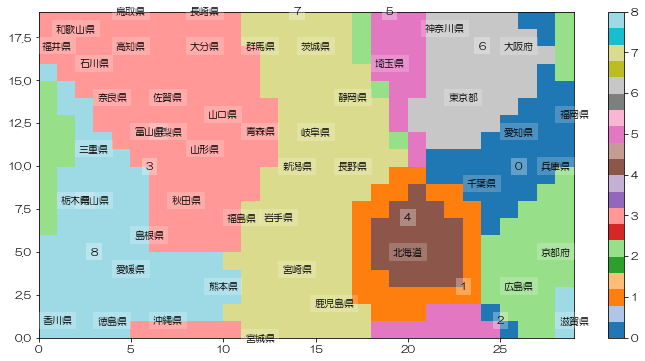

In [13]:
# 12-means
W = som.K
labelimage, centers = kmeans(W,9,100)
somcenters = [som.forward1(c)  for c in centers]
plt.rcParams['font.family'] = 'HGMaruGothicMPRO'
fig = plt.figure(figsize=(12,6))
plotBoundary(labelimage, somcenters)
writePref(som,pref,stdX,dataindex)

# 課題

標準化ではなく正規化を用いて同じ実験を試みよ

In [14]:
with open("kendata.csv", encoding="utf-8") as f:
    print(f.read())

﻿都道府県,人口,面積,人口密度,外国人,国籍不詳率,公務員,産業動物,小動物診療
愛知県,7507691 ,5173 ,1451 ,160228 ,0.0103 ,1671 ,395 ,92 
愛媛県,1374881 ,5676 ,242 ,7828 ,0.0058 ,397 ,123 ,34 
茨城県,2907262 ,6097 ,477 ,40477 ,0.0022 ,1145 ,216 ,124 
岡山県,1915401 ,7114 ,269 ,18476 ,0.0074 ,596 ,157 ,82 
沖縄県,1439913 ,2281 ,631 ,7651 ,0.0057 ,450 ,177 ,58 
岩手県,1268083 ,15275 ,83 ,5184 ,0.0019 ,628 ,137 ,162 
岐阜県,2022785 ,10621 ,190 ,36879 ,0.0032 ,664 ,215 ,36 
宮崎県,1095959 ,7735 ,142 ,3802 ,0.0034 ,652 ,226 ,209 
宮城県,2329431 ,7282 ,320 ,12367 ,0.0043 ,653 ,199 ,125 
京都府,2605731 ,4612 ,565 ,41855 ,0.0139 ,649 ,151 ,19 
熊本県,1774538 ,7409 ,240 ,7624 ,0.0062 ,655 ,187 ,126 
群馬県,1966381 ,6362 ,309 ,35458 ,0.0042 ,647 ,186 ,107 
広島県,2838494 ,8479 ,335 ,31882 ,0.0118 ,717 ,205 ,63 
香川県,972156 ,1877 ,518 ,6858 ,0.0079 ,343 ,104 ,29 
高知県,720907 ,7104 ,101 ,3172 ,0.0042 ,259 ,91 ,19 
佐賀県,828388 ,2441 ,339 ,3594 ,0.0027 ,255 ,98 ,34 
埼玉県,7288081 ,3798 ,1919 ,88734 ,0.0071 ,1967 ,345 ,73 
三重県,1807611 ,5774 ,313 ,32825 ,0.0051 ,455 ,149 ,39 
山形県,